In [1]:
%matplotlib inline

-----------------------------------------------

c:\users\christian\documents\github\svg_model\svg_model\data_frame.py:36: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  close_points.reset_index()]).sort(df_svg.columns[:3]


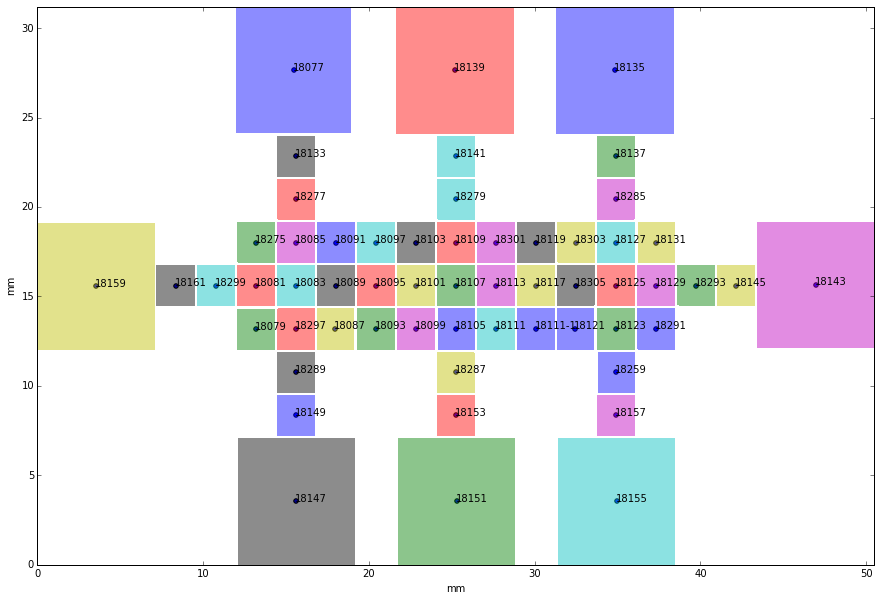

In [2]:
from IPython.display import display
import matplotlib.pyplot as plt 
import droplet_planning as dp
from droplet_planning.plot import plot_paths
from droplet_planning.connections import extract_adjacent_paths, get_adjacency_matrix
# from droplet_planning.cycles import extract_adjacent_paths

svg_filepath = 'test_device_1.svg'

# Read device layout from SVG file.
df_paths = dp.get_scaled_svg_frame(svg_filepath)

fig, axis = plt.subplots(figsize=(15, 10))
plot_paths(df_paths, labelsize=10, axis=axis)

## Drawing the Connections

In [3]:
# Extract [adjacency list][1] from paths data frame.
#
# [1]: https://en.wikipedia.org/wiki/Adjacency_list
df_connected = extract_adjacent_paths(df_paths)
df_connected['cost'] = 1

c:\users\christian\documents\github\droplet-planning\droplet_planning\connections.py:74: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  .sort(axis=1, ascending=False).sort(['source', 'destination']))
c:\users\christian\documents\github\droplet-planning\droplet_planning\connections.py:74: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  .sort(axis=1, ascending=False).sort(['source', 'destination']))


In [4]:
# The following returns one row per electrode, indexed by electrode path id
df_path_centers = (df_paths.drop_duplicates(['path_id'])
                   .set_index('path_id')[['x_center', 'y_center']])
adjacency_matrix, indexed_paths, path_indexes = get_adjacency_matrix(df_connected)
df_indexed_path_centers = df_path_centers.loc[path_indexes.index].reset_index()
df_indexed_path_centers.rename(columns={'index': 'path_id'}, inplace=True)

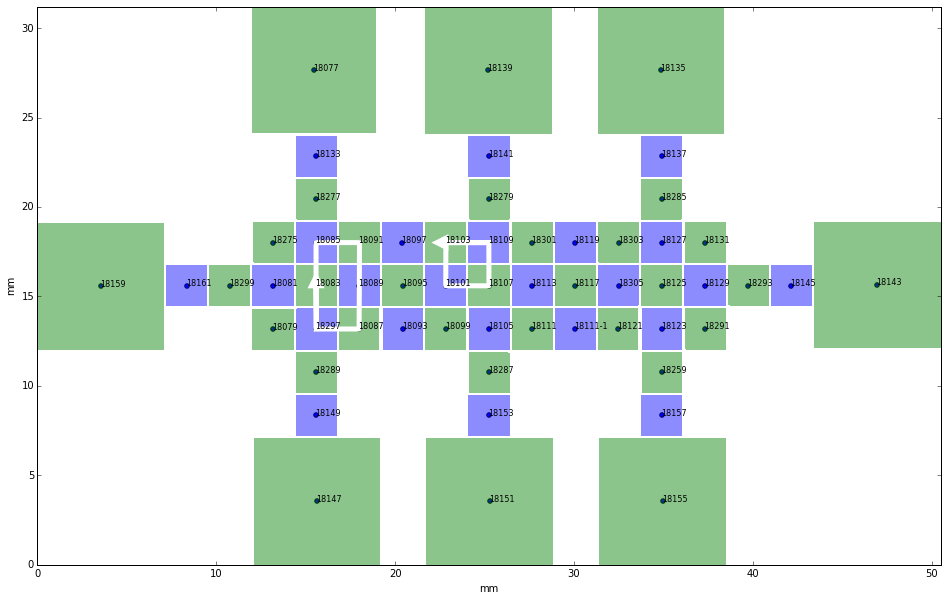

In [5]:
from droplet_planning.plot import draw_device, draw_path
from droplet_planning.cycles import find_cycle_enumerate


axis = draw_device(df_paths, df_connected)
# Get reference to cycling color generator.
colors = axis._get_lines.color_cycle

cycles = [path_indexes.loc[['path18083', 'path18085',
                            'path18087', 'path18089',
                            'path18091', 'path18297']],
          path_indexes.loc[['path18103', 'path18107',
                            'path18101', 'path18109']]]

for nodes_i in cycles:
    solution_i = find_cycle_enumerate(nodes_i, adjacency_matrix)
    draw_path(axis, df_indexed_path_centers, solution_i)

axis.get_figure().savefig('connection-graph.pdf', bbox_inches='tight')

In [6]:
def permutations(iterable, r=None):
    # permutations('ABCD', 2) --> AB AC AD BA BC BD CA CB CD DA DB DC
    # permutations(range(3)) --> 012 021 102 120 201 210
    pool = tuple(iterable)
    n = len(pool)
    r = n if r is None else r
    if r > n:
        return
    indices = range(n)
    cycles = range(n, n-r, -1)
#     yield tuple(pool[i] for i in indices[:r])
    yield indices[:r], cycles
    print cycles
    while n:
        for i in xrange(r - 1, -1, -1):
#         for i in reversed(range(r)):
            cycles[i] -= 1
            if cycles[i] == 0:
                indices[i:] = indices[i+1:] + indices[i:i+1]
                # Roll indices[i:] left one position.
                #
                #    [-------- X xxxxxxxxx]
                #              ^ ^
                #              | |
                #              i i+1
                #    [-------- xxxxxxxxx X]
                #              ^         ^  
                #              |         |  
                #              i+1       i  
                print i, 'roll indices[%d:] left:' % i, cycles, indices
                cycles[i] = n - i
            else:
                j = cycles[i]
                indices[i], indices[-j] = indices[-j], indices[i]
                print i, 'swap indices %d <-> %d:  %s %s' % (i, n-j, cycles, indices)
                print '<break> (reset i = %d)' % (r - 1)
#                 yield tuple(pool[i] for i in indices[:r])
                yield indices[:r], cycles
                break
        else:  # No break.
            return